In [1]:
import json

#import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

#scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:

connection = Connection()
db = connection.recipe_db
input_data = db.recipes_test_copy
#data = pd.DataFrame(list(input_data.find()))

data = json.loads(json_util.dumps(input_data.find()))
norm_data = json_normalize(data)



#schmeiss alle zutaten raus, die weniger als 4 mal verwendet werden
# ingredients_unique = ingredients[ingredients.groupby('ingredients_id').ingredients_id.transform(len) > 4]

# drop duplicate by a column name
 
# ingredients_unique.drop_duplicates(['ingredients_id'], keep='last')

# ingredients_unique = ingredients_unique.drop(ingredients_unique.columns[[0, 3, 4]], axis=1)

# ingredients_unique['ingredients_id'].value_counts()



In [4]:
ingredients = json_normalize(data, record_path='ingredients', meta='id', record_prefix='ingredients_', errors='ignore' )
ingredients = pd.DataFrame(ingredients)

In [5]:
nutritions = json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count'])


In [6]:
# data cleansing

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
ingredients_filt = ingredients.groupby('ingredients_id').filter(lambda x: len(x) >= 5)

# drop alls rows with ingredients_id == 0
ingredients_filt = ingredients_filt[ingredients_filt.ingredients_id != 0]

# drop all duplicate
ingredients_filt = ingredients_filt.drop_duplicates(keep='first')

ingredients.id.count()
ingredients.id.nunique()
ingredients_filt.id.count()
ingredients_filt.id.nunique()

61194

6304

57865

6304

In [7]:
id_list = [215014, 8669, 16700, 16354, 12720, 8652, 8887, 51283, 45954, 213742, 14595, 219164, 16348, 143082, 8665, 11758, 223042, 236609, 8778, 65896, 24264, 11679, 141678, 9023]


recipe_db = pd.get_dummies(ingredients_filt['ingredients_id']).groupby(ingredients_filt['id']).apply(max)



In [8]:
# recipe_db.index.nunique()
recipe_db.count()
nutritions.id.count()

111      6304
126      6304
257      6304
388      6304
443      6304
         ... 
26706    6304
26934    6304
27343    6304
27388    6304
27805    6304
Length: 796, dtype: int64

126080

In [9]:
#filtere Rezepte aus den Metadaten anhand ihrerr Zutatenmenge raus. 
not_wanted_recipes = recipe_db[recipe_db.mask(recipe_db==0).count(axis=1) <= 4]
not_wanted_recipes
mask = nutritions['id'].isin(not_wanted_recipes.index.values)
nutritions_filt = nutritions.loc[~mask]
# nutritions_filt.id.nunique()
nutrition_db = nutritions_filt.pivot_table(
        index=['id'], 
         columns=['name'],
         values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)
#remove multiindex 'amount'

nutrition_db.columns = nutrition_db.columns.droplevel(0)
# nutritions_filt.set_index('id', inplace=True)
nutrition_db = nutrition_db.dropna()
nutrition_db.index.nunique()

,111,126,257,388,443,445,578,615,629,631,...,24850,24865,25518,25522,26269,26706,26934,27343,27388,27805
id,,,,,,,,,,,,,,,,,,,,,
8496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5753

In [10]:
recipe_db_filt = recipe_db[recipe_db.mask(recipe_db==0).count(axis=1) >= 5]

user_nutrition = nutrition_db[nutrition_db.index.isin(id_list)]
user_recipes = recipe_db_filt[recipe_db_filt.index.isin(id_list)]
# user_nutrition.columns = user_nutrition.columns.droplevel(0)
user_nutrition.index.nunique()
user_recipes.index.nunique()

22

22

In [11]:
# remove recipes which are missing in nutrition df from the ingredients tecipes dataframe
mask = recipe_db_filt.index.isin(nutrition_db.index.values)
recipe_db = recipe_db_filt.loc[mask]

recipe_db

,111,126,257,388,443,445,578,615,629,631,...,24850,24865,25518,25522,26269,26706,26934,27343,27388,27805
id,,,,,,,,,,,,,,,,,,,,,
6806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
## Jaccard - rezept zu rezept vergelich

result_array = cdist(user_recipes, recipe_db,'jaccard')
result_2 = pd.DataFrame(result_array, columns=recipe_db.index.values, index=user_recipes.index.values)
# result_2

result_10 = pd.DataFrame(result_2.sum(), columns=['jaccard_distance_sum'])
result_10 = result_10.sort_values(by='jaccard_distance_sum')

result_10

,jaccard_distance_sum
102235,18.40949
11732,18.45941
16416,18.58403
25927,18.58730
8887,18.64538
...,...
34912,22.00000
17610,22.00000
57243,22.00000
15699,22.00000


In [13]:
out = result_10.hist(column='jaccard_distance_sum', bins=200)
out

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cce36d0>]],
      dtype=object)

In [14]:
##Euklidische Distanz - rezept zu rezept vergelich
# minkowski(u, v, p=2, w=None)
# rec = []
# rec = {
#     "Calcium":[1],
#     "Calories":[1],
#     "Calories from Fat":[1],
#     "Carbohydrates":[1],
#     "Cholesterol":[1],
#     "Dietary Fiber":[1],
#     "Fat":[1],
#     "Folate":[1],
#     "Iron":[1],
#     "Magnesium":[1],
#     "Niacin Equivalents":[1],
#     "Potassium":[1],
#     "Protein":[1],
#     "Saturated Fat":[1],
#     "Sodium":[1],
#     "Sugars":[1],
#     "Thiamin":[1],
#     "Vitamin A - IU":[1],
#     "Vitamin B6":[1],
#     "Vitamin C":[1]}

rec_2 = [
    #"Calcium":[1],
    1,
   # "Calories":[1],
    1,
   # "Calories from Fat":[1],
    1,
    #"Carbohydrates":[1],
    1,
    #"Cholesterol":[1],
    1,
    #"Dietary Fiber	":[1],
    1,
    #"Fat":[1],
    1,
    #"Folate":[1],
    1,
    #"Iron":[1],
    1,
    #"Magnesium":[1],
    1,
    #"Niacin Equivalents":[1],
    1,
    #"Potassium":[1],
    1,
    #"Protein":[1],
    1,
    #"Saturated Fat":[1],
    1,
    #"Sodium":[1],
    1,
    #"Sugars":[1],
    1,
    #"Thiamin":[1],
    1,
    #"Vitamin A - IU":[1],
    1,
    #"Vitamin B6":[1],
    1,
    #"Vitamin C":[1]}
    1]

# nutrition_db = nutrition_db[:-700]
# nutrition_db = nutrition_db.dropna()  
result_array = cdist(user_nutrition, nutrition_db,'minkowski', p = 2, w= rec_2)
result_2 = pd.DataFrame(result_array, columns=nutrition_db.index.values, index=user_nutrition.index.values)
# result_2

result_6 = pd.DataFrame(result_2.sum(), columns=['minkowski_distance_sum'])
result_6 = result_6.sort_values(by='minkowski_distance_sum')


In [15]:
test = result_6
test2 = result_10
# result_6.describe()
# out = result_6.hist(column='minkowski_distance_sum', bins=2000)
# out

In [16]:
result_6 = result_6[:-700]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120adee90>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120adec50>]],
      dtype=object)

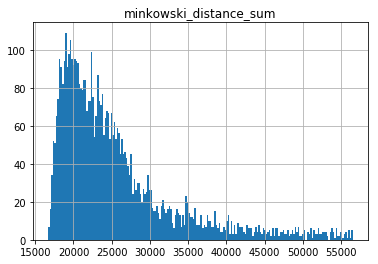

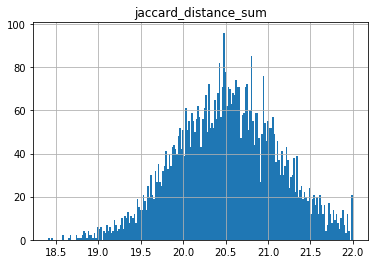

In [17]:
# result_6.describe()
out1 = result_6.hist(column='minkowski_distance_sum', bins=200)
out2 = result_10.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [18]:
outliers = test[test['minkowski_distance_sum'] > test['minkowski_distance_sum'].mean() + 1 * test['minkowski_distance_sum'].std()]


In [19]:
test.drop(outliers.index, inplace=True)

In [20]:
test.describe()
test2.describe()

,minkowski_distance_sum
count,5434.00000
mean,28946.75837
std,14851.89705
min,16702.14863
25%,20316.91889
50%,23765.18232
75%,29939.53658
max,102106.75712


,jaccard_distance_sum
count,5753.00000
mean,20.52258
std,0.60560
min,18.40949
25%,20.10286
50%,20.52340
75%,20.94773
max,22.00000


In [21]:
test2 = test2[test2.index.isin(test.index)]
test2

,jaccard_distance_sum
102235,18.40949
11732,18.45941
16416,18.58403
25927,18.58730
8887,18.64538
...,...
34912,22.00000
17610,22.00000
57243,22.00000
15699,22.00000


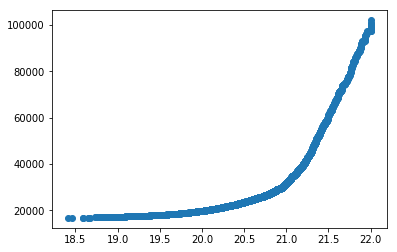

In [22]:
import pylab
pylab.scatter(test2.jaccard_distance_sum, test.minkowski_distance_sum)

In [23]:

# outliers

# # test2.drop(outliers.index, inplace=True)
# test2
result_6 = test
result_10 = test2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1203c8910>]],
      dtype=object)

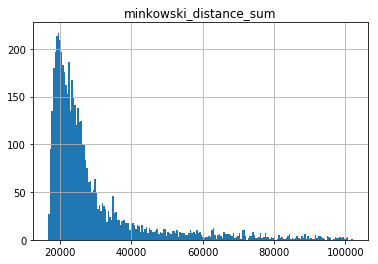

In [24]:
test1 = test.hist(column='minkowski_distance_sum', bins=200)
test1

In [25]:
result_6 = test

In [26]:
#minmax nomralisierung
from sklearn import preprocessing

nut_res = result_6
x = nut_res.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
# jac_res = jac_res.reset_index()
nut_res = pd.DataFrame(x_scaled, columns=nut_res.columns, index=nut_res.index)
# result_6 = pd.DataFrame(x_scaled, columns=result_6.columns)


jac_res = result_10
z = jac_res.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
# jac_res = jac_res.reset_index()
jac_res = pd.DataFrame(z_scaled, columns=jac_res.columns, index=jac_res.index)

min_max_nut_recipe = pd.DataFrame(nut_res.minkowski_distance_sum + jac_res.jaccard_distance_sum, columns=jac_res.columns, index=jac_res.index)
min_max_nut_recipe = min_max_nut_recipe.sort_values(by='jaccard_distance_sum')
min_max_nut_recipe.rename(columns={'jaccard_distance_sum': 'min_max_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12139b550>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12128ce90>]],
      dtype=object)

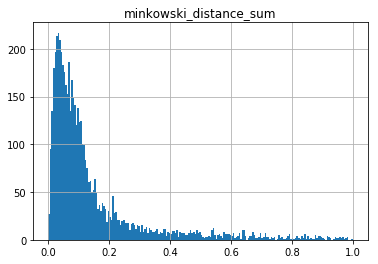

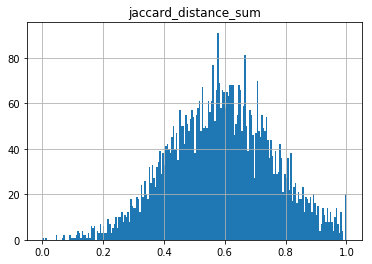

In [27]:
out1 = nut_res.hist(column='minkowski_distance_sum', bins=200)
out2 = jac_res.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [28]:
display_side_by_side(jac_res, nut_res, min_max_nut_recipe)

,jaccard_distance_sum
102235,0.00000
11732,0.01390
16416,0.04861
25927,0.04952
8887,0.06570
51372,0.07035
223042,0.07178
132511,0.09063
55860,0.09278
213487,0.09654


In [29]:
display(jac_res, nut_res, min_max_nut_recipe)

,jaccard_distance_sum
102235,0.00000
11732,0.01390
16416,0.04861
25927,0.04952
8887,0.06570
...,...
34912,1.00000
17610,1.00000
57243,1.00000
15699,1.00000


,minkowski_distance_sum
72845,0.00000
180791,0.00033
213742,0.00048
8621,0.00110
217080,0.00152
...,...
185519,0.97657
88912,0.98128
213117,0.98140
11747,0.98433


,min_max_nut_recipe
25927,0.06808
16416,0.07430
102235,0.07527
51372,0.08113
8887,0.08640
...,...
14670,1.72717
49769,1.73241
229874,1.75853
178054,1.78275


In [30]:
#robust-normalisierung
from sklearn import preprocessing

nut_res_robust = result_6
x = nut_res_robust.values #returns a numpy array
robust_scaler = preprocessing.RobustScaler()
x_scaled = robust_scaler.fit_transform(x)
# jac_res = jac_res.reset_index()
nut_res_robust = pd.DataFrame(x_scaled, columns=nut_res_robust.columns, index=nut_res_robust.index)
# result_6 = pd.DataFrame(x_scaled, columns=result_6.columns)


jac_res_robust = result_10
z = jac_res_robust.values #returns a numpy array
robust_scaler = preprocessing.RobustScaler()
z_scaled = robust_scaler.fit_transform(z)
# jac_res_robust = jac_res_robust.reset_index()
jac_res_robust = pd.DataFrame(z_scaled, columns=jac_res_robust.columns, index=jac_res_robust.index)



robust_scaling_nut_recipe = pd.DataFrame(nut_res_robust.minkowski_distance_sum + jac_res_robust.jaccard_distance_sum, columns=jac_res_robust.columns, index=jac_res_robust.index)
robust_scaling_nut_recipe = robust_scaling_nut_recipe.sort_values(by='jaccard_distance_sum')
robust_scaling_nut_recipe.rename(columns={'jaccard_distance_sum': 'robust_scaling_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122828cd0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1228287d0>]],
      dtype=object)

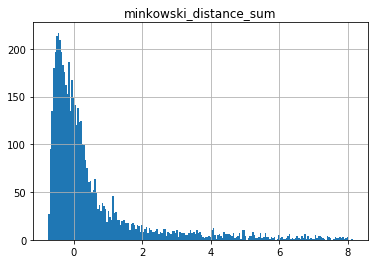

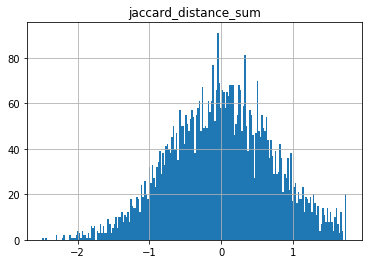

In [31]:
out1 = nut_res_robust.hist(column='minkowski_distance_sum', bins=200)
out2 = jac_res_robust.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [32]:
display_side_by_side(jac_res_robust, nut_res_robust)

,jaccard_distance_sum
102235,-2.49420
11732,-2.43533
16416,-2.28838
25927,-2.28452
8887,-2.21602
51372,-2.19633
223042,-2.19026
132511,-2.11046
55860,-2.10137
213487,-2.08543


In [33]:
#z-score-mormalisierung
z_min = (result_6 - result_6.mean())/result_6.std()
z_jac = (result_10 - result_10.mean())/result_10.std()

z_score_nut_recipe = pd.DataFrame(z_min.minkowski_distance_sum + z_jac.jaccard_distance_sum, columns=result_6.columns, index=z_min.index)
z_score_nut_recipe = z_score_nut_recipe.sort_values(by='minkowski_distance_sum')
z_score_nut_recipe.rename(columns={'minkowski_distance_sum': 'z_score_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121001b50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12119fa50>]],
      dtype=object)

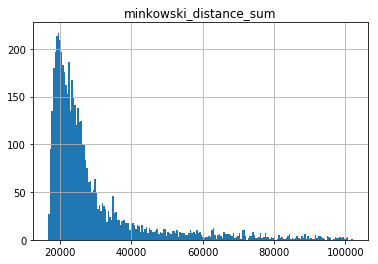

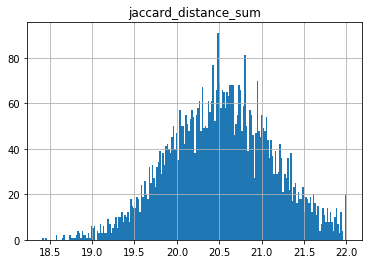

In [34]:
out1 = result_6.hist(column='minkowski_distance_sum', bins=200)
out2 = result_10.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [35]:
display_side_by_side(result_6, result_10)

,minkowski_distance_sum
72845,16702.14863
180791,16730.38907
213742,16742.89884
8621,16795.87569
217080,16831.60880
219461,16844.14176
90497,16850.39094
103503,16929.36462
223381,16958.73016
84745,16977.73425


In [36]:
z_scaled

array([[-2.49420319],
       [-2.43533402],
       [-2.2883766 ],
       ...,
       [ 1.73996593],
       [ 1.73996593],
       [ 1.73996593]])

In [37]:
# summed_up = pd.DataFrame(columns='sum')
# result_6['sum'] = result_6.minkowski_distance_sum + result_10.jaccard_distance_sum
# result_6


In [38]:
display(result_6, result_10)

,minkowski_distance_sum
72845,16702.14863
180791,16730.38907
213742,16742.89884
8621,16795.87569
217080,16831.60880
...,...
185519,100106.04066
88912,100508.13498
213117,100517.98473
11747,100768.83295


,jaccard_distance_sum
102235,18.40949
11732,18.45941
16416,18.58403
25927,18.58730
8887,18.64538
...,...
34912,22.00000
17610,22.00000
57243,22.00000
15699,22.00000


In [39]:
display(result_6, result_10, min_max_nut_recipe, z_score_nut_recipe, robust_scaling_nut_recipe)


,minkowski_distance_sum
72845,16702.14863
180791,16730.38907
213742,16742.89884
8621,16795.87569
217080,16831.60880
...,...
185519,100106.04066
88912,100508.13498
213117,100517.98473
11747,100768.83295


,jaccard_distance_sum
102235,18.40949
11732,18.45941
16416,18.58403
25927,18.58730
8887,18.64538
...,...
34912,22.00000
17610,22.00000
57243,22.00000
15699,22.00000


,min_max_nut_recipe
25927,0.06808
16416,0.07430
102235,0.07527
51372,0.08113
8887,0.08640
...,...
14670,1.72717
49769,1.73241
229874,1.75853
178054,1.78275


,z_score_nut_recipe
25927,-3.89195
102235,-3.85758
16416,-3.85634
51372,-3.81399
8887,-3.78432
...,...
14670,5.75902
49769,5.80669
229874,5.95381
178054,6.08237


,robust_scaling_nut_recipe
25927,-2.85381
51372,-2.83464
16416,-2.79442
8887,-2.76627
223042,-2.74672
...,...
160197,8.50997
20082,8.53390
178054,8.58266
47022,8.61871


In [40]:
robust_scaling_nut_recipe.index.values[:10]

array([ 25927,  51372,  16416,   8887, 223042, 102235, 213487,  19126,
        86047,  26619])

In [41]:
user_nutrition.describe()

name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000
mean,159.99189,419.63661,202.54957,22.71136,108.69271,1.34103,22.50551,36.94701,2.34085,43.52666,14.29797,438.18231,30.30979,9.28729,914.82474,8.84147,0.22279,633.25011,0.54481,9.44859
std,204.64150,195.67102,127.00564,17.72938,57.42293,1.63049,14.11174,45.25523,1.38049,18.53427,5.82148,163.29511,10.81204,9.46412,421.18443,7.88883,0.23264,945.08919,0.25715,26.70116
min,16.54100,188.82200,63.26972,3.69344,49.55834,0.09812,7.02997,4.03500,0.67555,20.15258,6.12173,204.87420,15.14428,1.32642,261.17500,0.31000,0.04379,44.29399,0.22325,0.17663
25%,30.61873,289.89323,108.42730,11.71574,67.95188,0.29512,12.04748,11.17081,1.38157,29.70595,10.71160,334.04520,22.99077,3.16964,638.66735,2.94898,0.08939,141.86822,0.32555,2.08205
50%,64.30737,357.60735,180.02090,14.72541,96.42354,0.73333,20.00232,21.23022,1.91907,38.62819,11.50875,399.83440,28.34294,7.03607,896.44645,7.62589,0.15629,359.73285,0.50139,2.74364
75%,241.05728,475.43077,236.67387,31.33663,128.23378,1.44693,26.29710,31.97973,3.29331,54.11189,19.11362,502.88567,37.15344,9.84844,1129.72975,12.07341,0.28818,613.08930,0.73764,5.35917
max,863.07260,934.62580,555.39700,66.65271,270.80000,6.01560,61.71077,165.90260,6.70979,90.07227,25.98078,913.57040,61.73117,37.16240,2203.72100,30.60239,1.09490,4342.76200,1.10925,128.18110


In [42]:
display(jac_res_robust, nut_res_robust, robust_scaling_nut_recipe)

,jaccard_distance_sum
102235,-2.49420
11732,-2.43533
16416,-2.28838
25927,-2.28452
8887,-2.21602
...,...
34912,1.73997
17610,1.73997
57243,1.73997
15699,1.73997


,minkowski_distance_sum
72845,-0.73400
180791,-0.73107
213742,-0.72977
8621,-0.72426
217080,-0.72055
...,...
185519,7.93348
88912,7.97527
213117,7.97629
11747,8.00236


,robust_scaling_nut_recipe
25927,-2.85381
51372,-2.83464
16416,-2.79442
8887,-2.76627
223042,-2.74672
...,...
160197,8.50997
20082,8.53390
178054,8.58266
47022,8.61871


In [43]:
import matplotlib.pyplot as plt

#df.plot(kind='scatter',x='year',y='value')
#plt.show()

In [53]:
result_6[:10].index.values

array([ 72845, 180791, 213742,   8621, 217080, 219461,  90497, 103503,
       223381,  84745])

In [54]:
# nutrition_db.isnull().values.sum()
# nutrition_db
# df1 = nutrition_db[nutrition_db.isnull().any(axis=1)]

# df1
# result_6['minkowski_distance_sum']
user_nutrition.describe()

name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000
mean,159.99189,419.63661,202.54957,22.71136,108.69271,1.34103,22.50551,36.94701,2.34085,43.52666,14.29797,438.18231,30.30979,9.28729,914.82474,8.84147,0.22279,633.25011,0.54481,9.44859
std,204.64150,195.67102,127.00564,17.72938,57.42293,1.63049,14.11174,45.25523,1.38049,18.53427,5.82148,163.29511,10.81204,9.46412,421.18443,7.88883,0.23264,945.08919,0.25715,26.70116
min,16.54100,188.82200,63.26972,3.69344,49.55834,0.09812,7.02997,4.03500,0.67555,20.15258,6.12173,204.87420,15.14428,1.32642,261.17500,0.31000,0.04379,44.29399,0.22325,0.17663
25%,30.61873,289.89323,108.42730,11.71574,67.95188,0.29512,12.04748,11.17081,1.38157,29.70595,10.71160,334.04520,22.99077,3.16964,638.66735,2.94898,0.08939,141.86822,0.32555,2.08205
50%,64.30737,357.60735,180.02090,14.72541,96.42354,0.73333,20.00232,21.23022,1.91907,38.62819,11.50875,399.83440,28.34294,7.03607,896.44645,7.62589,0.15629,359.73285,0.50139,2.74364
75%,241.05728,475.43077,236.67387,31.33663,128.23378,1.44693,26.29710,31.97973,3.29331,54.11189,19.11362,502.88567,37.15344,9.84844,1129.72975,12.07341,0.28818,613.08930,0.73764,5.35917
max,863.07260,934.62580,555.39700,66.65271,270.80000,6.01560,61.71077,165.90260,6.70979,90.07227,25.98078,913.57040,61.73117,37.16240,2203.72100,30.60239,1.09490,4342.76200,1.10925,128.18110


In [55]:
top_10_nut = nutrition_db[nutrition_db.index.isin(result_6.index.values[:10])]
top_10_nut_recipes = nutrition_db[nutrition_db.index.isin(robust_scaling_nut_recipe.index.values[:10])]
top_10_recipes = nutrition_db[nutrition_db.index.isin(result_10.index.values[:10])]

In [56]:
top_10_nut_recipes.describe()


name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
mean,113.08263,409.50205,158.23974,28.05950,125.11302,0.98586,17.58219,33.38433,2.76941,46.41153,18.86825,415.31958,32.78278,6.20572,720.26548,13.09110,0.17927,431.94138,0.62786,4.53554
std,102.97072,62.86011,66.65381,20.64175,47.96677,0.67657,7.40598,21.32923,1.16976,7.55565,3.67850,74.61490,6.70460,3.93848,207.85948,20.76221,0.08097,284.86249,0.13707,3.70941
min,25.29167,251.92330,39.15535,5.86644,67.15000,0.30134,4.35060,12.48452,1.64963,37.19234,11.60242,270.78120,24.74052,0.86821,415.83740,0.17941,0.08824,174.91980,0.39408,0.05250
25%,52.59079,394.38932,117.88067,13.70432,86.55375,0.52006,13.09785,20.98977,1.96224,40.20914,17.19161,373.19418,27.52419,2.39617,598.89905,1.17517,0.13634,214.57910,0.55362,2.13887
50%,92.58028,426.17450,151.18705,23.85017,116.99585,0.65041,16.79856,30.17782,2.33993,44.43012,19.47245,399.74040,31.85963,7.08952,689.67365,2.83436,0.16088,383.49555,0.60815,3.06829
75%,103.00624,449.09537,219.25485,35.05898,167.64740,1.28939,24.36165,34.62590,3.31904,52.90005,20.15502,476.55443,38.46951,9.66364,808.77460,11.89110,0.18545,499.11685,0.70416,8.09599
max,380.24510,470.78190,239.76340,65.34917,194.44310,2.14114,26.64038,86.28219,5.50189,59.43013,25.84105,510.51830,42.46059,10.46830,1142.33500,55.98093,0.35498,1118.82800,0.90415,10.15195


In [57]:
nutrition_db.loc[[24717]]

name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
id,,,,,,,,,,,,,,,,,,,,
24717,28.33119,184.07580,46.74889,29.81351,0.00000,5.51020,5.19432,80.85445,1.85935,45.14994,3.62557,482.00310,6.20702,0.50533,147.12630,2.79534,0.17590,1790.43900,0.36008,10.57194


In [58]:
user_nutrition.describe()
top_10_recipes.describe()
top_10_nut.describe()

name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000,22.00000
mean,159.99189,419.63661,202.54957,22.71136,108.69271,1.34103,22.50551,36.94701,2.34085,43.52666,14.29797,438.18231,30.30979,9.28729,914.82474,8.84147,0.22279,633.25011,0.54481,9.44859
std,204.64150,195.67102,127.00564,17.72938,57.42293,1.63049,14.11174,45.25523,1.38049,18.53427,5.82148,163.29511,10.81204,9.46412,421.18443,7.88883,0.23264,945.08919,0.25715,26.70116
min,16.54100,188.82200,63.26972,3.69344,49.55834,0.09812,7.02997,4.03500,0.67555,20.15258,6.12173,204.87420,15.14428,1.32642,261.17500,0.31000,0.04379,44.29399,0.22325,0.17663
25%,30.61873,289.89323,108.42730,11.71574,67.95188,0.29512,12.04748,11.17081,1.38157,29.70595,10.71160,334.04520,22.99077,3.16964,638.66735,2.94898,0.08939,141.86822,0.32555,2.08205
50%,64.30737,357.60735,180.02090,14.72541,96.42354,0.73333,20.00232,21.23022,1.91907,38.62819,11.50875,399.83440,28.34294,7.03607,896.44645,7.62589,0.15629,359.73285,0.50139,2.74364
75%,241.05728,475.43077,236.67387,31.33663,128.23378,1.44693,26.29710,31.97973,3.29331,54.11189,19.11362,502.88567,37.15344,9.84844,1129.72975,12.07341,0.28818,613.08930,0.73764,5.35917
max,863.07260,934.62580,555.39700,66.65271,270.80000,6.01560,61.71077,165.90260,6.70979,90.07227,25.98078,913.57040,61.73117,37.16240,2203.72100,30.60239,1.09490,4342.76200,1.10925,128.18110


name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
mean,144.00247,425.06256,165.65204,28.69348,124.55261,1.14560,18.40578,37.26433,2.79314,44.87937,19.45932,409.12550,33.95319,6.37494,607.43392,12.33962,0.21458,564.24640,0.62813,7.70798
std,139.37758,85.23723,87.99041,20.68821,64.96371,0.97848,9.77671,35.69333,1.43672,6.90685,3.70738,103.80310,8.57354,4.82269,293.71035,20.82380,0.15193,532.09071,0.15423,7.38966
min,25.29167,281.09490,39.15535,7.73663,26.76500,0.30134,4.35060,12.48452,1.64963,35.30719,12.84158,245.54810,19.51922,0.86821,68.50747,0.71481,0.08824,78.06052,0.33847,0.31717
25%,50.13097,382.48585,102.58561,13.99968,70.07305,0.52006,11.39840,23.07030,1.92413,39.87703,17.51903,372.70870,29.20909,2.25444,447.63848,1.33815,0.13885,228.13563,0.54248,2.63378
50%,78.09958,426.17450,151.18705,20.77136,121.09915,0.65041,16.79856,30.17782,2.10934,43.82519,19.47245,399.74040,31.85963,6.13725,666.77660,2.50621,0.17966,383.49555,0.64084,6.37716
75%,171.37772,450.86380,219.25485,40.32211,183.97553,1.81021,24.36165,33.30678,2.86956,50.32322,20.81093,476.55443,41.69333,9.66364,708.13075,5.97767,0.20230,598.79517,0.71437,9.96586
max,403.05880,609.15640,338.58360,65.34917,209.06540,3.18902,37.62040,136.42630,5.50189,54.33805,25.84105,572.17100,46.42546,14.61483,1142.33500,55.98093,0.61774,1826.21400,0.90415,25.17116


name,Calcium,Calories,Calories from Fat,Carbohydrates,Cholesterol,Dietary Fiber,Fat,Folate,Iron,Magnesium,Niacin Equivalents,Potassium,Protein,Saturated Fat,Sodium,Sugars,Thiamin,Vitamin A - IU,Vitamin B6,Vitamin C
count,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
mean,136.33213,345.42946,152.65456,20.69623,108.10927,1.71419,16.96162,41.25662,3.56072,39.02229,10.85712,448.67185,26.42950,6.78264,902.18132,4.88907,0.16266,397.01976,0.37887,5.93929
std,37.57817,37.97663,21.69945,9.27521,30.05263,1.32194,2.41105,20.68715,1.42956,7.23199,4.01099,54.93376,5.29400,2.06118,48.43737,3.97891,0.08540,64.82769,0.13804,7.87707
min,86.76228,296.23620,110.44530,7.18940,60.45750,0.00000,12.27169,7.45945,1.84539,26.95290,7.42968,381.77960,19.37722,3.05193,811.81400,0.74203,0.05990,261.97970,0.21866,0.53566
25%,113.99648,317.20833,149.91983,14.62711,96.59905,0.83687,16.65776,30.43740,2.81122,33.98755,7.91664,403.27575,22.18044,6.35906,877.16720,2.40666,0.10726,365.53670,0.30262,2.05343
50%,130.78940,343.55740,152.24270,19.06601,104.47250,1.35537,16.91586,35.83767,3.22543,41.07985,10.41650,435.54830,26.74507,6.73470,909.96805,3.33099,0.14139,393.56930,0.34778,3.96938
75%,158.36077,357.57332,165.26022,27.60174,126.55313,2.49572,18.36224,55.34531,4.17206,42.78743,11.82378,503.46632,30.28250,8.41422,938.68412,6.42490,0.18746,443.61760,0.42636,4.98516
max,215.66520,422.86510,180.26490,37.40684,162.57200,4.55371,20.02943,78.95753,6.70979,50.91137,21.05468,518.91770,35.07648,9.21249,956.70750,13.62401,0.31373,496.41950,0.71773,27.53070


In [59]:
# user_nutrition['Vitamin B6'].median()
user_nutrition['Fat'].median()

20.002319999999997

In [60]:
#remove multiindex 'amount'
# user_nutrition.columns = user_nutrition.columns.droplevel(0)
# nutrition_db.columns = nutrition_db.columns.droplevel(0)